In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import xarray as xr

In [2]:
data = xr.load_dataset('../../input_data/moce5/moce5_dataset.cdf', decode_timedelta=False)
simu_diusst = np.load('../../output_files/simu_diusst.npy', allow_pickle=True)
simu_zb05 = np.load('../../output_files/simu_zb05.npy', allow_pickle=True)
simu_slab = np.load('../../output_files/simu_slab.npy', allow_pickle=True)
simu_const = np.load('../../output_files/simu_const.npy', allow_pickle=True)

T_f = float(data.T_f)
ref_idx = 20
time_pts = data['time_day'].to_numpy()[:-1]

dsst_diusst = simu_diusst[0][:,0] - simu_diusst[0][:,ref_idx]
dsst_zb05 = simu_zb05[0]
dsst_slab = simu_slab[0] - T_f

flux_diusst = simu_diusst[3][0] + simu_diusst[3][1] + simu_diusst[3][2]
flux_zb05 = simu_zb05[2][0] + simu_zb05[2][1] + simu_zb05[2][2]
flux_slab = simu_slab[1][0] + simu_slab[1][1] + simu_slab[1][2]
flux_const = simu_const[1][0] + simu_const[1][1] + simu_const[1][2]

training_int1 = np.arange(96,413,1)
training_int2 = np.arange(1290,1585,1)
training_idx = np.concatenate((training_int1, training_int2))
validation_int1 = np.arange(0,96,1)
validation_int2 = np.arange(413,1290,1)
validation_int3 = np.arange(1585,1851,1)
validation_idx = np.concatenate((np.concatenate((validation_int1, validation_int2)),validation_int3))

model_r = stats.pearsonr(data['dsst'][:-1],dsst_diusst)[0]
zb05_r = stats.pearsonr(data['dsst'][:-1],dsst_zb05)[0]
slab_r = stats.pearsonr(data['dsst'][:-1],dsst_slab)[0]

print('Reference depth: {:.3f} m'.format(simu_diusst[2][ref_idx]))
print(model_r, zb05_r, slab_r)

Reference depth: -3.045 m
0.735214475425641 0.7199918317275554 0.4985037395462531


/home/reykiboy/.local/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


/tmp/ipykernel_10838/3877739840.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


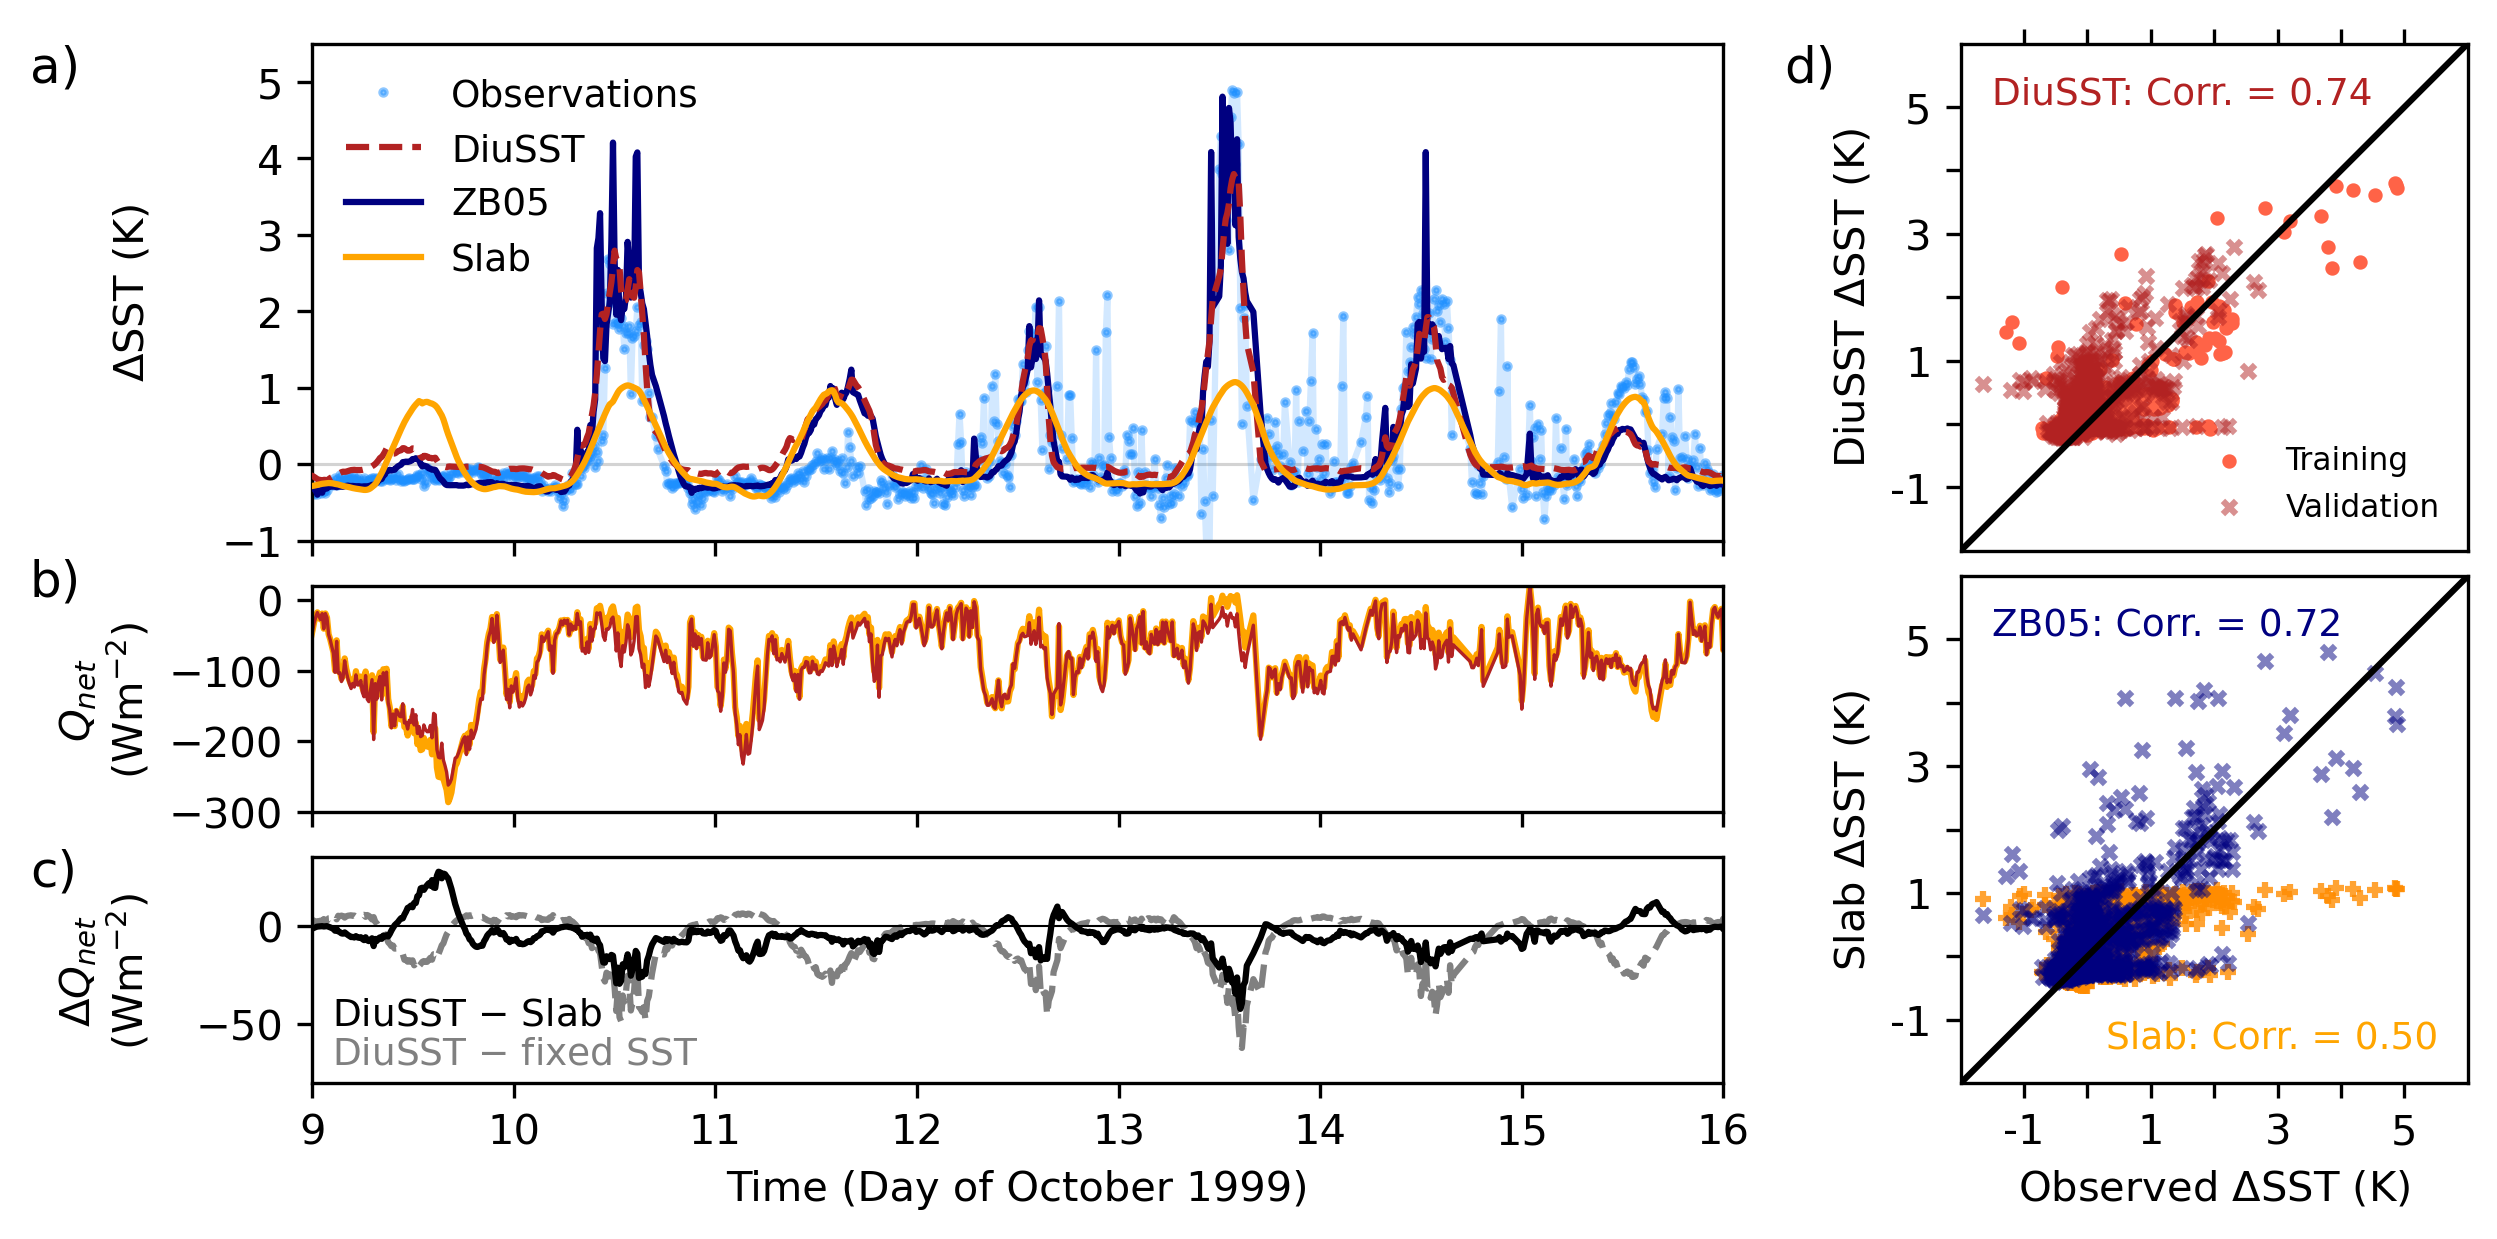

In [13]:
xmin, xmax = -2, 6

fig = plt.figure(dpi=300,figsize=(9.5,4.5))
gs = GridSpec(2, 3, wspace=0.3, hspace=0.05)
gs2 = gs[:,0:2].subgridspec(4,1)
ax1 = fig.add_subplot(gs2[0:2])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,2])
ax1b = fig.add_subplot(gs2[2])
ax1c = fig.add_subplot(gs2[3])

ax1.plot(data['time_day'],data['dsst'],alpha=0.2,c='dodgerblue')
ax1.plot(data['time_day'],data['dsst'],'.',markersize=3,alpha=0.5,c='dodgerblue', label='Observations')
ax1.plot(time_pts,dsst_diusst,c='firebrick', label='DiuSST', ls='--', zorder=9)
ax1.plot(time_pts,dsst_zb05, c='navy', label='ZB05', zorder=8)
ax1.plot(time_pts,dsst_slab, c='orange', label='Slab',zorder=10)
ax1.axhline(y=0,c='lightgray',zorder=0,lw=0.75)
ax1.legend(frameon=False,loc='upper left', fontsize=9)
ax1.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=[None]*21)#np.arange(0,21)+1)
ax1.set(xlim=(8,15),ylim=(-1,5.5))
ax1.set(yticks=[-1,0,1,2,3,4,5])

ax1b.plot(time_pts, flux_diusst, c='firebrick',label='Model - Slab',zorder=2,lw=.8)
ax1b.plot(time_pts, flux_slab, c='orange', label='Model - const.',zorder=1,lw=1.5)

ax1b.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=[None]*21)
ax1b.set(xlim=(8,15),ylim=(None,None), ylabel='$Q_{net}$\n(Wm$^{-2}$)')

ax1c.plot(time_pts, (flux_diusst-flux_slab), c='k')
ax1c.plot(time_pts, (flux_diusst-flux_const), c='gray', ls='--', zorder=-1)
ax1c.set(xlim=(0,20.5),xticks=np.arange(0,21),xticklabels=np.arange(0,21)+1)
ax1c.set(xlim=(8,15),ylim=(None,None), ylabel='$\Delta Q_{net}$\n(Wm$^{-2}$)')
ax1c.axhline(y=0, lw=0.5, c='k', zorder=-1)

ax2.plot([xmin,xmax],[xmin,xmax],c='k')
ax2.scatter(data['dsst'][training_idx],dsst_diusst[training_idx],c='tomato',marker='o',s=6, label='Training')
ax2.scatter(data['dsst'][validation_idx],dsst_diusst[validation_idx],c='firebrick',marker='x',s=10,alpha=.5, label='Validation')
ax2.legend(loc='lower right', fontsize=7.5, frameon=False)

ax3.plot([xmin,xmax],[xmin,xmax],c='k',zorder=10)
ax3.scatter(data['dsst'][:-1],dsst_slab,c='darkorange',marker='+',s=15,alpha=.8,zorder=4)
ax3.scatter(data['dsst'][:-1],dsst_zb05,c='navy',marker='x',s=10,alpha=.5,zorder=5)

ax2.tick_params(axis='x', bottom=False, top=True, labelbottom=False, labeltop=False)
ax2.set(xticks=[-1,0,1,2,3,4,5],xticklabels=['-1',None,'1',None,'3',None,'5'])
ax3.set(xticks=[-1,0,1,2,3,4,5],xticklabels=['-1',None,'1',None,'3',None,'5'])
ax2.set(yticks=[-1,0,1,2,3,4,5],yticklabels=['-1',None,'1',None,'3',None,'5'])
ax3.set(yticks=[-1,0,1,2,3,4,5],yticklabels=['-1',None,'1',None,'3',None,'5'])

ax2.set_aspect(1)
ax3.set_aspect(1)
ax2.set(xlim=(xmin,xmax),ylim=(xmin,xmax))
ax2.set(xlim=(xmin,xmax),ylim=(xmin,xmax))
ax3.set(xlim=(xmin,xmax),ylim=(xmin,xmax))
ax3.set(xlim=(xmin,xmax),ylim=(xmin,xmax))

ax2.set(ylabel='DiuSST $\Delta$SST (K)')
ax3.set(xlabel='Observed $\Delta$SST (K)',ylabel='Slab $\Delta$SST (K)')
ax1.set(ylabel='$\Delta$SST (K)')
ax1c.set(xlabel='Time (Day of October 1999)')

ax2.text(-1.5,5.5,'DiuSST: Corr. = {:.2f}'.format(model_r), fontsize=9, va='top', color='firebrick')
ax3.text(-1.5,5.5,'ZB05: Corr. = {:.2f}'.format(zb05_r), fontsize=9, va='top', color='navy')
ax3.text(0.3,-1.,'Slab: Corr. = {:.2f}'.format(slab_r), fontsize=9, va='top', color='orange')

ax1.text(6.6,5.5,'a)', fontsize=12,va='top')
ax1b.text(6.6,60,'b)', fontsize=12,va='top')
ax1c.text(6.6,40,'c)', fontsize=12,va='top')
ax1.text(15.3,5.5,'d)', fontsize=12,va='top')
#ax1b.legend()

ax1c.set(ylim=(-80,35))
ax1b.set(ylim=(-300,20))
ax1b.set(yticks=[-300,-200,-100,0])
ax1c.text(8.1,-50, 'DiuSST $-$ Slab', c='k', fontsize=9)
ax1c.text(8.1,-70, 'DiuSST $-$ fixed SST', c='gray', fontsize=9)

fig.align_ylabels()
plt.tight_layout()

plt.savefig("fig6_j2.png", bbox_inches="tight")

plt.show()

In [14]:
print(np.mean(flux_diusst))
print(np.mean(flux_zb05))
print(np.mean(flux_slab))
print(np.mean(flux_const))

-103.00085510657148
-96.39704451133834
-99.32296074578029
-97.52545487153007


In [15]:
print(np.mean(flux_diusst-flux_const))
print(np.mean(flux_zb05-flux_const))
print(np.mean(flux_slab-flux_const))

-5.475400235041413
1.1284103601917401
-1.7975058742502281


[Text(0.5, 1.0, 'Diurnal warming dSST (K)')]

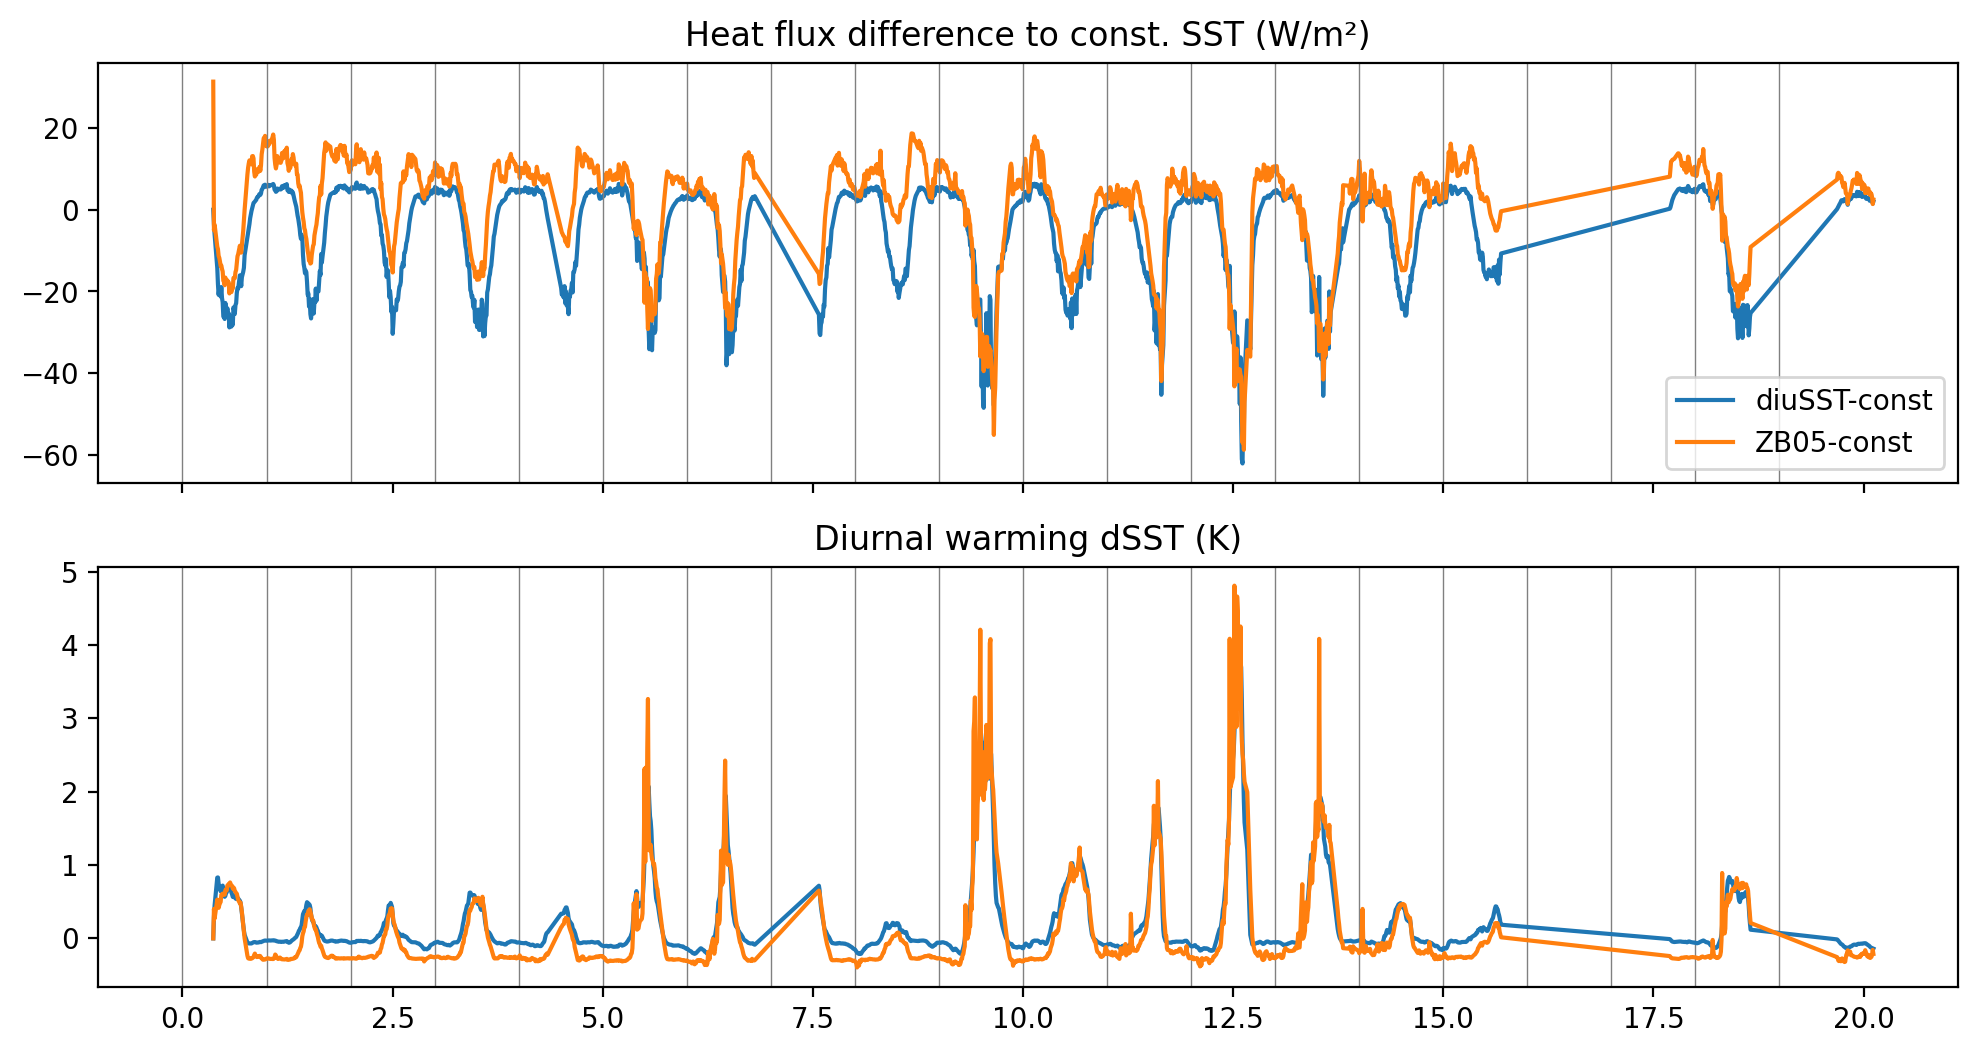

In [36]:
fig, ax = plt.subplots(2,1, dpi=200, figsize=(12,6), sharex=True)
ax[0].plot(time_pts, flux_diusst-flux_const, label="diuSST-const")
ax[0].plot(time_pts, flux_zb05-flux_const, label='ZB05-const')
for i in range(20):
    ax[0].axvline(x=i, c='gray', lw=0.5)
    ax[1].axvline(x=i, c='gray', lw=0.5)
ax[0].legend()

ax[1].plot(time_pts, dsst_diusst)
ax[1].plot(time_pts, dsst_zb05)

ax[0].set(title="Heat flux difference to const. SST (W/m²)")
ax[1].set(title="Diurnal warming dSST (K)")

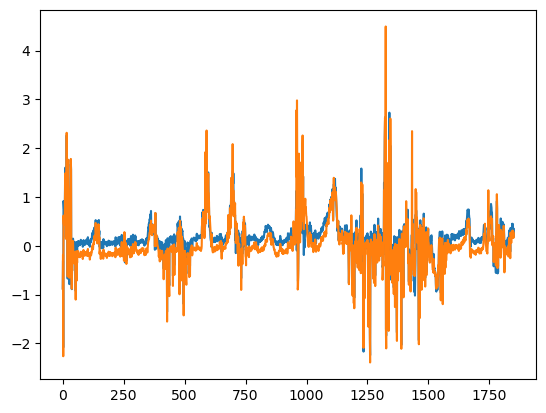

In [41]:
fig, ax = plt.subplots()
ax.plot(dsst_diusst-data['dsst'][1:])
ax.plot(dsst_zb05-data['dsst'][1:])

In [48]:
print(np.mean((dsst_diusst-data['dsst'].data[1:])**2))
print(np.mean((dsst_zb05-data['dsst'].data[1:])**2))

0.20460521341768378
0.23270680067458596


In [53]:
print(np.mean(dsst_diusst))
print(np.mean(dsst_zb05))
print(np.mean(data['dsst'].data))

0.1933983606451504
0.06852486394569114
0.04097354211665273


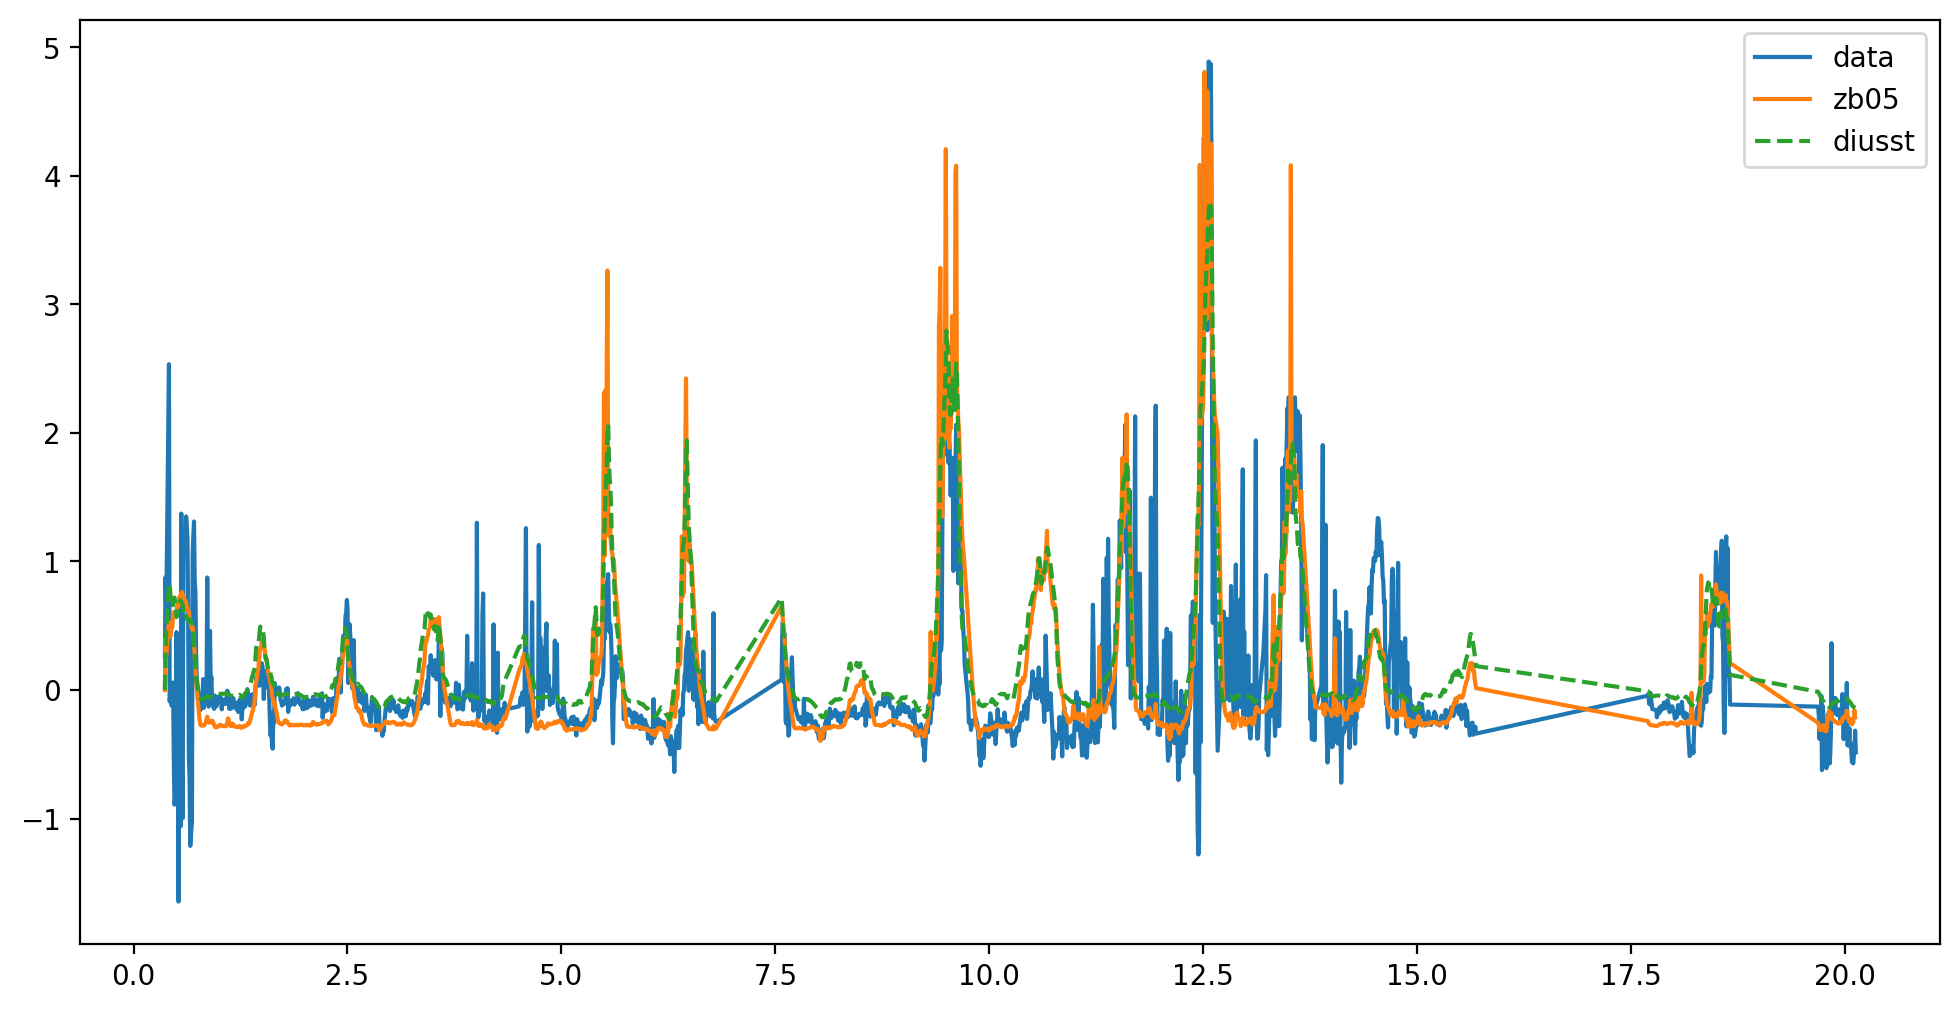

In [58]:
fig, ax = plt.subplots(dpi=200, figsize=(12,6))
ax.plot(data['time_day'], data['dsst'], label='data')
ax.plot(time_pts, dsst_zb05, label='zb05')
ax.plot(time_pts, dsst_diusst, label='diusst', ls='--')
ax.legend()